In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer

from sklearn import linear_model
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Data Analysis

### Import cleaned data file

In [172]:
data=pd.read_csv('C:/Users/Anne_2/Documents/Ironhack/Fifa_Moneyball-Case-Study/fifa21_cleaned.csv')

In [173]:
#view data
data.head()

,id,name,age,ova,nationality,club,bp,height,weight,foot,...,gk_reflexes,pac,sho,pas,dri,def,phy,gender,position,market_value
0,16,Luis García,37,71,Spain,KAS Eupen,CM,"5'10""",143lbs,Right,...,11,53,69,73,69,58,63,Male,midfielder,0.6
1,41,Iniesta,36,81,Spain,Vissel Kobe,CAM,"5'7""",150lbs,Right,...,7,58,70,85,85,63,59,Male,midfielder,5.5
2,80,E. Belözoğlu,38,77,Turkey,Fenerbahçe SK,CM,"5'7""",159lbs,Left,...,8,44,71,83,77,62,66,Male,midfielder,2.8
3,330,R. Keane,35,80,Republic of Ireland,LA Galaxy,CF,"5'9""",161lbs,Right,...,16,68,82,75,82,31,69,Male,forward,5.5
4,1179,G. Buffon,42,82,Italy,Juventus,GK,"6'4""",203lbs,Right,...,78,77,76,74,78,33,91,Male,keeper,2.2


#### There are 34 'basic' skills in the data set with a score between 0 and 100. There are also 6 indices (pac,	sho, pas, dri, def, phy) in the data which are calculated using the 34 basic skills - also having a range from 0 to 100. In the original data set there are another 6 indices out of the 34 basic skills in a different composition but these indices have a different range (values can be higher than 100).

#### Since the calculation method of the indices in the data set isn't 100% clear, the analysis will start with a factor analysis of the 34 basic skills, so that the factors can be used in a regression analysis on market value. This will also allow a more detailed analysis than using the already calculated indices.

## Factor Analysis of basic skills

In [174]:
data.columns

Index(['id', 'name', 'age', 'ova', 'nationality', 'club', 'bp', 'height',
       'weight', 'foot', 'value', 'wage', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'pac',
       'sho', 'pas', 'dri', 'def', 'phy', 'gender', 'position',
       'market_value'],
      dtype='object')

In [175]:
#Standardize variables for factor analysis
factors=data[['crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]
transformer = StandardScaler().fit(factors)
factors = pd.DataFrame(transformer.transform(factors), columns=factors.columns)

In [176]:
#Bartlett test - are variables uncorrelated?
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(factors)
print('Chi_square:', chi_square_value, '; p_value:', p_value)

Chi_square: 791454.2961172038 ; p_value: 0.0


In [177]:
#KMO test - measure of sampling adequacy for whole model (should be at least 0.5, best between 0.85 and 1) 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_model=calculate_kmo(factors)
print(kmo_model)

(array([0.98486161, 0.97298238, 0.96247161, 0.96814615, 0.98603326,
       0.97802705, 0.97799106, 0.97415165, 0.96291575, 0.97550124,
       0.9261291 , 0.92931045, 0.97728513, 0.93306176, 0.95925541,
       0.96440942, 0.86756023, 0.98709081, 0.82589862, 0.97484251,
       0.98442721, 0.9616226 , 0.97851187, 0.98027659, 0.98572264,
       0.98098025, 0.98009368, 0.90973658, 0.91136016, 0.98076712,
       0.98268309, 0.98535015, 0.98269791, 0.98051946]), 0.970116067650148)


C:\Users\Anne_2\anaconda3\lib\site-packages\factor_analyzer\utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


#### --> MSA per variable, as well as KMO for whole model way above 0.5, all variables can be taken into account

In [178]:
#Choosing number of factors - could choose 6 factors, to replicate the given indices in dataset or
#using Kaiser Criterion to choose factors based on eigenvalues (eigenvalue > 1)

#Initial Factor analysis with as many factors as variables
fa = FactorAnalyzer(n_factors=34, rotation=None, method='principal')
fa.fit(factors)

#get the Eigenvalues
fa.get_eigenvalues()

(array([17.75250033,  5.25819106,  2.80049731,  1.86566797,  1.3672949 ,
         0.62153033,  0.4938456 ,  0.38483424,  0.33386741,  0.31224638,
         0.28570655,  0.25886543,  0.22735048,  0.21154783,  0.20911086,
         0.19064759,  0.16447915,  0.14512111,  0.13658922,  0.13069418,
         0.11407283,  0.09927054,  0.09230268,  0.08501972,  0.06992013,
         0.06724365,  0.06417539,  0.060506  ,  0.03919148,  0.03889783,
         0.03413188,  0.03317895,  0.02904051,  0.02246044]),
 array([17.75250033,  5.25819106,  2.80049731,  1.86566797,  1.3672949 ,
         0.62153033,  0.4938456 ,  0.38483424,  0.33386741,  0.31224638,
         0.28570655,  0.25886543,  0.22735048,  0.21154783,  0.20911086,
         0.19064759,  0.16447915,  0.14512111,  0.13658922,  0.13069418,
         0.11407283,  0.09927054,  0.09230268,  0.08501972,  0.06992013,
         0.06724365,  0.06417539,  0.060506  ,  0.03919148,  0.03889783,
         0.03413188,  0.03317895,  0.02904051,  0.02246044]))

#### --> there are 5 factors with eigenvalue > 1

In [179]:
#Factor analyses with 5 factors
fa = FactorAnalyzer(n_factors=5, method='principal', rotation='varimax')
fa.fit(factors)

#get the loadings of variables on factors
print(pd.DataFrame(fa.loadings_,index=factors.columns))

                         0         1         2         3         4
crossing          0.626388  0.355619  0.280383  0.459245 -0.088347
finishing         0.773278 -0.229538  0.435871  0.261066  0.078301
heading_accuracy  0.301851  0.361845  0.660509 -0.096922  0.451340
short_passing     0.663488  0.483669  0.374819  0.249330  0.039375
volleys           0.805423 -0.117302  0.401138  0.202207  0.085762
dribbling         0.681904  0.164594  0.463171  0.460216 -0.006410
curve             0.786279  0.167113  0.268123  0.329852 -0.084320
fk_accuracy       0.785646  0.204184  0.217667  0.211629 -0.136400
long_passing      0.634382  0.599408  0.160241  0.182383 -0.069007
ball_control      0.686412  0.290477  0.488819  0.348185  0.063991
acceleration      0.259523  0.003859  0.335293  0.835635  0.094688
sprint_speed      0.229107 -0.000632  0.374271  0.783954  0.167215
agility           0.444495  0.038438  0.182250  0.791745  0.003231
reactions         0.583090  0.295054 -0.332940 -0.034321  0.44

#### --> the skills for goalkeeping - are all loading negatively on the extracted factors, especially on factor 3, which has only "heading_accuracy" loading above 0.5 in positive direction. It makes interpretation of this factor complicated - 'bad goalkeeper' isn't a desirable skill. Furhermore, a huge bunch of skills loads very high on factor 1, while factors 2, 4 and 5 only combine high loads from very few skills.
#### --> Possible explanation: the skillset of a player depends on the position the player is trained for - especially goalkeeping seems to be its very unique skillset which is even correlating negatively with the other skills.
#### --> Solution: spliiting dataset by position already for factor analysis.

In [180]:
#splitting dataset by position
positions = data.groupby(data.position)
data_forward = positions.get_group('forward')
data_midfielder = positions.get_group('midfielder')
data_defender = positions.get_group('defender')
data_keeper = positions.get_group('keeper')

In [181]:
#resetting index of new dataframes to avoid problems later when concatenating with factors from factor analysis
#(factors will have index from 0 to size of subdataset, subdata has index from original dataframe)
data_forward = data_forward.reset_index()
data_midfielder = data_midfielder.reset_index()
data_defender = data_defender.reset_index()
data_keeper = data_keeper.reset_index()

In [182]:
#crosscheck with value counts in whole dataset:
print(data['position'].value_counts())
print('Midfielder dataset:', data_midfielder.shape)
print('Defender dataset:', data_defender.shape)
print('Forward dataset: ', data_forward.shape)
print('Keeper dataset:', data_keeper.shape)

midfielder    5895
defender      4755
forward       2306
keeper        1353
Name: position, dtype: int64
Midfielder dataset: (5895, 56)
Defender dataset: (4755, 56)
Forward dataset:  (2306, 56)
Keeper dataset: (1353, 56)


## 1. Factor Analysis for forwarders

In [183]:
#splitting dataset
factors_forward=data_forward[['crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]

#Bartlett test - are variables uncorrelated?
chi_square_value,p_value=calculate_bartlett_sphericity(factors_forward)
print('Chi_square:', chi_square_value, '; p_value:', p_value)
                    
#KMO test - measure of sampling adequacy for whole model (should be at least 0.5, best between 0.85 and 1) 
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_model=calculate_kmo(factors_forward)
print(kmo_model)

Chi_square: 53635.00191804673 ; p_value: 0.0
(array([0.96859606, 0.95849612, 0.95166482, 0.96961183, 0.97773763,
       0.94118133, 0.94895332, 0.95068984, 0.95328435, 0.95323201,
       0.75475371, 0.73854874, 0.89779722, 0.97344509, 0.80763715,
       0.96695632, 0.84385143, 0.93530464, 0.87164588, 0.96770026,
       0.95593631, 0.95403171, 0.95440301, 0.97491405, 0.96791263,
       0.97968737, 0.97162709, 0.85651102, 0.828074  , 0.74301942,
       0.72724652, 0.8096026 , 0.60865453, 0.73021412]), 0.9409411375356272)


In [184]:
#Choosing number of factors (Eigenvalue >1)
fa = FactorAnalyzer(n_factors=34, method='principal', rotation=None)
fa.fit(factors_forward)
fa.get_eigenvalues()

(array([11.49145037,  3.78926957,  2.60938005,  1.68063065,  1.24531156,
         1.01521042,  0.97495172,  0.95400224,  0.926222  ,  0.88907233,
         0.83085867,  0.68626734,  0.6538289 ,  0.56450116,  0.54727125,
         0.5136154 ,  0.42808854,  0.38433355,  0.34902837,  0.34562164,
         0.33285111,  0.31998224,  0.30945702,  0.27400813,  0.25965951,
         0.24476682,  0.23481582,  0.22613558,  0.21327381,  0.19811043,
         0.14412895,  0.13698221,  0.12481173,  0.10210089]),
 array([11.49145037,  3.78926957,  2.60938005,  1.68063065,  1.24531156,
         1.01521042,  0.97495172,  0.95400224,  0.926222  ,  0.88907233,
         0.83085867,  0.68626734,  0.6538289 ,  0.56450116,  0.54727125,
         0.5136154 ,  0.42808854,  0.38433355,  0.34902837,  0.34562164,
         0.33285111,  0.31998224,  0.30945702,  0.27400813,  0.25965951,
         0.24476682,  0.23481582,  0.22613558,  0.21327381,  0.19811043,
         0.14412895,  0.13698221,  0.12481173,  0.10210089]))

#### --> 6 factors with eigenvalue > 1

In [186]:
#Factor analyses with 6 factors
fa = FactorAnalyzer(n_factors=6, method='principal', rotation='varimax')
fa.fit(factors_forward)

#get the loadings of variables on factors
print(pd.DataFrame(fa.loadings_,index=factors_forward.columns))

                         0         1         2         3         4         5
crossing          0.609154  0.259216  0.400133 -0.169412  0.048471 -0.186939
finishing         0.826686 -0.036190 -0.058772  0.193836 -0.004407  0.191040
heading_accuracy  0.578684 -0.354253  0.095086  0.442331  0.005270  0.293578
short_passing     0.808190  0.099184  0.267806  0.084738 -0.011279 -0.042480
volleys           0.812352 -0.065477  0.116125  0.131822  0.056454  0.100009
dribbling         0.767763  0.419048  0.077003  0.023878 -0.010006 -0.097852
curve             0.705142  0.059160  0.237158 -0.243809  0.068988 -0.103665
fk_accuracy       0.658039 -0.057381  0.260645 -0.261607  0.112784 -0.098411
long_passing      0.609951  0.111789  0.484236 -0.093653  0.016349 -0.158306
ball_control      0.852533  0.163481  0.118691  0.139373 -0.002992  0.018905
acceleration     -0.045035  0.918626 -0.015299 -0.145892 -0.009775  0.011714
sprint_speed     -0.051819  0.910153 -0.029257  0.010944 -0.011018 -0.013769

#### --> there are two factors (4 and 6), that have only one skill with positive loading > 0.5 (strength for factor 4 and jumping for factor 6) and additionally some skills are not loading above 0.5 on any of the factors --> reducing factors to 5.

In [187]:
#Factor analyses with 5 factors
fa = FactorAnalyzer(n_factors=5, method='principal', rotation='varimax')
fa.fit(factors_forward)

#get the loadings of variables on factors
print(pd.DataFrame(fa.loadings_,index=factors_forward.columns))

                         0         1         2         3         4
crossing          0.594225  0.286059  0.428803 -0.160442  0.029042
finishing         0.830361 -0.066346 -0.062816  0.250715  0.001907
heading_accuracy  0.587966 -0.441714  0.072478  0.439195  0.019790
short_passing     0.799950  0.067937  0.284630  0.078165 -0.028649
volleys           0.812655 -0.083121  0.119055  0.152326  0.058680
dribbling         0.753969  0.378613  0.103371  0.062598 -0.046401
curve             0.699624  0.140276  0.258328 -0.224722  0.073879
fk_accuracy       0.655128  0.038768  0.279105 -0.260924  0.125529
long_passing      0.597441  0.125747  0.507801 -0.114516  0.001249
ball_control      0.845689  0.116407  0.132273  0.163680 -0.021990
acceleration     -0.064987  0.902477 -0.003958  0.102351 -0.041794
sprint_speed     -0.073284  0.834848 -0.016234  0.208154 -0.059835
agility           0.178050  0.851477  0.019036  0.018456  0.003402
reactions         0.794056 -0.013286  0.140140  0.276800  0.03

#### Factor loadings sorted
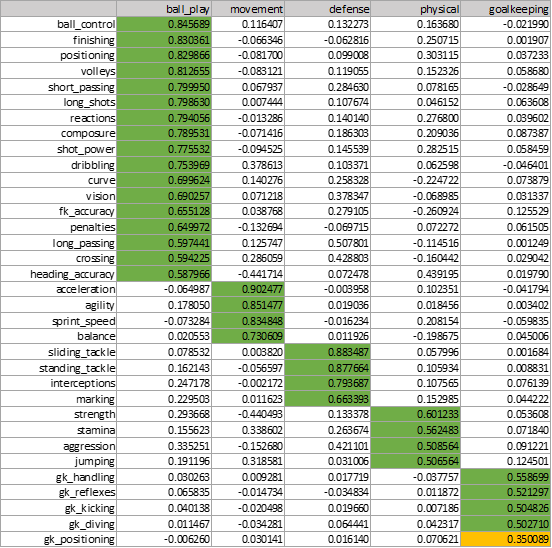

In [188]:
#get the variance explained by factors
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                         0         1         2         3         4
Variance          9.783021  3.740272  3.857454  2.122014  1.313255
Proportional Var  0.287736  0.110008  0.113455  0.062412  0.038625
Cumulative Var    0.287736  0.397744  0.511198  0.573611  0.612236


#### --> 61% of total variance is explained by the 5 extracted factors

In [189]:
#save factors to dataframe
forward_skills=pd.DataFrame(fa.transform(factors_forward), columns=['ball_play', 'movement', 'defense', 'physical', 'goalkeeping'])
data_forward=pd.concat([data_forward, forward_skills], axis=1)
data_forward.columns

Index(['index', 'id', 'name', 'age', 'ova', 'nationality', 'club', 'bp',
       'height', 'weight', 'foot', 'value', 'wage', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'fk_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'composure',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'pac',
       'sho', 'pas', 'dri', 'def', 'phy', 'gender', 'position', 'market_value',
       'ball_play', 'movement', 'defense', 'physical', 'goalkeeping'],
      dtype='object')

In [190]:
data_forward.shape

(2306, 61)

## 1b. Regression Analysis for forward

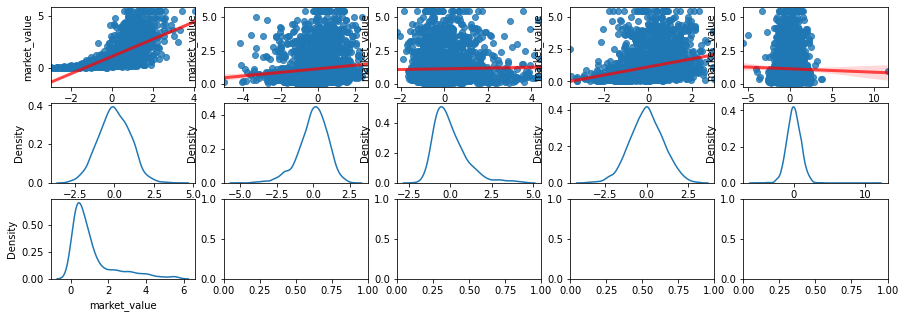

In [191]:
#Checking linear relationship and distribution
fig, ax = plt.subplots(3,5, figsize=(15,5))
sns.regplot(ax=ax[0,0], data=data_forward, x='ball_play', y='market_value', line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[0,1], data=data_forward, x='movement', y='market_value', line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[0,2], data=data_forward, x='defense', y='market_value', line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[0,3], data=data_forward, x='physical', y='market_value', line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[0,4], data=data_forward, x='goalkeeping', y='market_value', line_kws={"color":"r","alpha":0.7,"lw":3})
sns.kdeplot(data_forward['ball_play'], ax=ax[1,0])
sns.kdeplot(data_forward['movement'], ax=ax[1,1])
sns.kdeplot(data_forward['defense'], ax=ax[1,2])
sns.kdeplot(data_forward['physical'], ax=ax[1,3])
sns.kdeplot(data_forward['goalkeeping'], ax=ax[1,4])
sns.kdeplot(data_forward['market_value'], ax=ax[2,0])
plt.show()

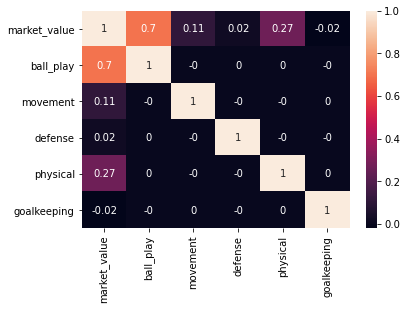

In [192]:
#Checking correlations matrix
regression_data=data_forward[['market_value', 'ball_play', 'movement', 'defense', 'physical', 'goalkeeping']]
sns.heatmap(round(regression_data.corr(),2), annot=True, annot_kws={"size": 10})
plt.show()

#### --> correlation matrix shows, that only ball_play has a high correlation with market_value, physical a low positive correlation and movement a very low correlation. Defense and goalkeeping are not correlated

In [193]:
# running regression with ball_play, movement and physical

#Defining independent (X) and dependent (Y) for regression
X = data_forward[['ball_play', 'movement', 'physical']]
Y = data_forward['market_value']

#No need to standardize X variables, as factors are already standardized

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     1030.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:19:40   Log-Likelihood:                -2665.8
No. Observations:                2306   AIC:                             5340.
Df Residuals:                    2302   BIC:                             5363.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1302      0.016     70.532      0.0

### About 50% of variance in market value of forward players is explained by the 3 factors ball_play, movement and physical. Ball_play is the biggest driver of the market value, it has about 2.5 times higher impact than physical skills and 7 to 8 times as much impact than movement (running fast, being agile etc).

### Model validation of regression

In [194]:
#Train test split
X_train,X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.40, random_state=100)

#Running linear regression
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.5721141082248088

In [195]:
y_test_predict=model.predict(X_test)
y_train_predict=model.predict(X_train)

residual_test = (y_test - y_test_predict)
residual_train = (y_train - y_train_predict)

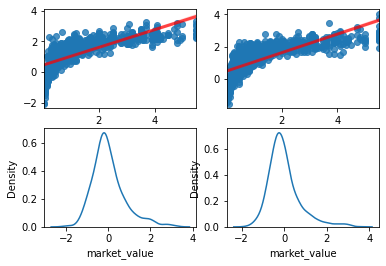

In [196]:
fig, ax = plt.subplots(2,2)

sns.regplot(ax=ax[0,0], x=y_test, y=y_test_predict, line_kws={"color":"r","alpha":0.7,"lw":3})
sns.regplot(ax=ax[0,1], x=y_train, y=y_train_predict, line_kws={"color":"r","alpha":0.7,"lw":3})
sns.kdeplot(residual_test, ax=ax[1,0])
sns.kdeplot(residual_train, ax=ax[1,1])
plt.show()